In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import torch 
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg16, VGG16_Weights

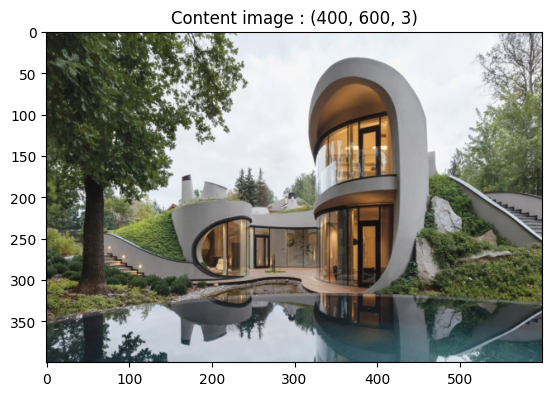

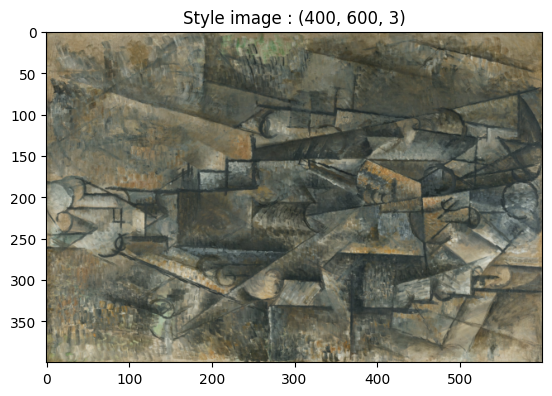

In [5]:
# Load a content image
content_img = plt.imread("img/house.jpg")
content_img = resize(content_img, (400, 600))[:, :, : 3]
plt.title("Content image : " + str(content_img.shape))
plt.imshow(content_img)
plt.show()

# Load a style image
style_img = plt.imread("img/picasso_clarinette.jpg")
style_img = resize(style_img, (600, 400)).transpose((1, 0, 2))[:, :, : 3]
plt.title("Style image : " + str(style_img.shape))
plt.imshow(style_img)
plt.show()

In [6]:
# A network that outputs intermediate VGG features
class Net(nn.Module):
    def __init__(self, vgg, layer_ids):
        super().__init__()
        for id in layer_ids:
            assert(id < len(vgg.features))
        self.vgg = vgg
        self.layer_ids = layer_ids
        
    def forward(self, x):
        outputs = []
        for i, layer in enumerate(self.vgg.features):
            x = layer(x)
            if i in self.layer_ids:
                outputs.append(x)
        return outputs
    

# Preprocess a numpy image so that it is in the format that VGG uses
def VGG_preprocess(img):
    mean = [0.48235, 0.45882, 0.40784]
    std = [0.00392156862745098, 0.00392156862745098, 0.00392156862745098]
    img = (img - mean) / std
    img = img.transpose((2, 0, 1))
    return img.astype(np.float32)

# Undo the preprocessing of VGG for a numpy image
def VGG_undo_preprocess(img):
    mean = [0.48235, 0.45882, 0.40784]
    std = [0.00392156862745098, 0.00392156862745098, 0.00392156862745098]
    img = img.transpose((1, 2, 0))
    img = img * std + mean
    return img.astype(np.float32)


In [7]:
assert(torch.cuda.is_available())
gpu = torch.device('cuda:0')

# Load the VGG network
vgg = vgg16(weights = VGG16_Weights.IMAGENET1K_FEATURES)
for param in vgg.parameters():
    param.requires_grad = False
vgg.eval()
net = Net(vgg, [0, 5, 10, 17, 24]).to(gpu)

In [8]:
vgg.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [9]:
content = torch.from_numpy(VGG_preprocess(content_img)).to(gpu)
style = torch.from_numpy(VGG_preprocess(style_img)).to(gpu)
# TODO : use a normal distribution instead
subject = torch.rand_like(content, dtype = torch.float32)
# LBFGS requires the input to be contiguous in memory
subject = subject.contiguous().detach()
subject = subject.requires_grad_().to(gpu)

In [10]:
def gram_matrix(feature):
    a, b, c = feature.shape
    feature = feature.view(a, b * c)
    return torch.mm(feature, feature.T) / (a * b * c)

def content_loss(featA, featB):
    return F.mse_loss(featA, featB)
    
def style_loss(featA, featB):
    return F.mse_loss(gram_matrix(featA), gram_matrix(featB))
    
def train(net, max_iters, lr, style_weights):
    optimizer = optim.LBFGS(params = [subject], lr = lr, line_search_fn = "strong_wolfe")
    content_features = net(content)
    style_features = net(style)

    def closure():
        optimizer.zero_grad()
        subject_features = net(subject)
        # Loss
        loss = content_loss(subject_features[-1], content_features[-1])
        for sub_feat, sty_feat, w in zip(subject_features, style_features, style_weights):
            loss += w * style_loss(sub_feat, sty_feat)
        # Compute gradients
        loss.backward()
        return loss

    LOG_FREQ = 5
    history = []
    for iter in range(max_iters):
        # Optimize
        optimizer.step(closure)
        # Print statistics
        if iter % LOG_FREQ == LOG_FREQ - 1:
            subject_features = net(subject)
            loss = content_loss(subject_features[-1], content_features[-1])
            print("%d content: %.4f style: " % (iter + 1, loss), end = "")
            for sub_feat, sty_feat, w in zip(subject_features, style_features, style_weights):
                L = w * style_loss(sub_feat, sty_feat)
                print("%.4f " % L, end = "")
                loss += L
            print("total: %.4f" % loss)
            history.append(loss.item())
          
    print('Finished Training')
    return history

[50 50 50 50 50]
5 content: 302.7229 style: 0.5704 5.4106 31.8032 148.9078 12.0782 total: 501.4930
10 content: 301.4586 style: 0.4083 4.2322 26.2664 136.2863 12.2817 total: 480.9335
15 content: 299.3062 style: 0.3361 3.7183 23.7897 130.7774 12.4307 total: 470.3584
20 content: 297.3804 style: 0.3030 3.4585 22.3249 127.6265 12.5214 total: 463.6147
25 content: 295.8212 style: 0.2835 3.2910 21.3718 125.4963 12.5876 total: 458.8514
30 content: 294.6624 style: 0.2744 3.1667 20.7926 123.9446 12.6327 total: 455.4732
35 content: 293.6780 style: 0.2673 3.0749 20.3279 122.9059 12.6716 total: 452.9257
40 content: 292.9527 style: 0.2622 3.0108 20.0204 122.0970 12.7046 total: 451.0476
45 content: 292.3533 style: 0.2575 2.9526 19.7714 121.5023 12.7289 total: 449.5660
50 content: 291.9068 style: 0.2554 2.9175 19.5579 120.9787 12.7499 total: 448.3663
Finished Training


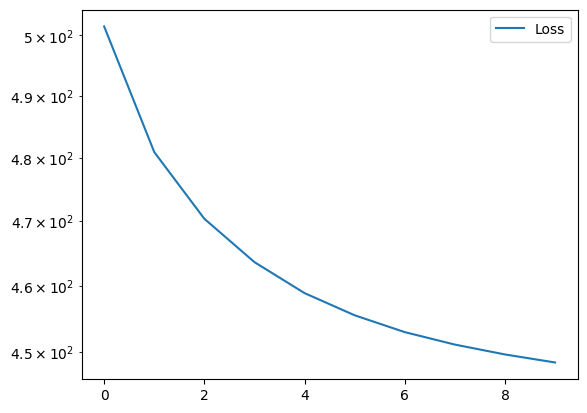

In [17]:
weights = np.full((5,), 50)
#weights[0] *= 1000
#weights[-1] = 1e-2

print(weights)

history = train(net, 50, lr = 1, style_weights = weights)
plt.semilogy(history, label = 'Loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


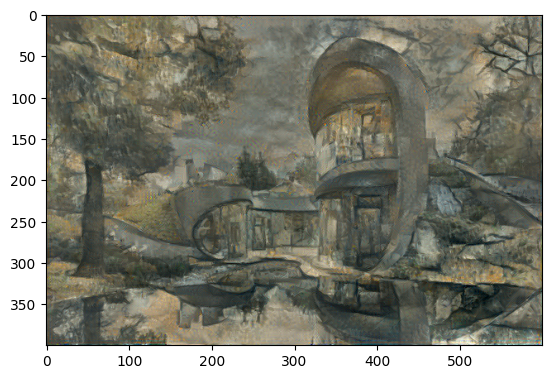

In [18]:
subject_img = subject.cpu().detach().numpy()
img = VGG_undo_preprocess(subject_img)
R, G, B = np.zeros(img.shape), np.zeros(img.shape), np.zeros(img.shape)
R[:, :, 0] = img[:, :, 0]
G[:, :, 1] = img[:, :, 1]
B[:, :, 2] = img[:, :, 2]

plt.imshow(img)
plt.show()
